$r_{n} = log(\frac{S_{n}}{S_{n-1}})$

$historical\ volatility: \hat{\sigma} = \sqrt{(\frac{1}{N-1})\sum_{n=1}^{N}(r_{n}-\hat{\mu})^{2}}$ 

$instantaneous\ volatility: dS_{t} = rS_{t}dt+\sigma S_{t}dZ_{t}$

$implied\ volatility: C_{0} = C^{BSM}(S_{0}, K, T, r, \sigma^{imp})$

$realized\ volatility: RV_{t} = \sqrt{\sum_{i=1}^{N}r_{t}^{2}}$

Converting geometric brownian motion of BSM to discrete version:

$S_{t} = S_{t-\Delta t}e^{(r-(1/2)\sigma^{2})\Delta t+\sigma\sqrt{\Delta t}z_{t}}$

t = ${\Delta t, 2\Delta t, ... T}$

$z_{t}$ = standard normally distributed random variables

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as scs
import quandl

sns.set_style('darkgrid')
%matplotlib inline

C:\Users\Alex\Miniconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [4]:
def generate_asset_price(S, r, sigma, dt, rand):
    return S * np.exp((r - sigma ** 2 / 2) * dt \
                + sigma * rand * math.sqrt(dt))

In [5]:
def simulate_gbm(S0, T, r, sigma, date_range, step_mult=252):
    '''
    Params
    -------------
    S0 = initial stock price
    T = # of years (can be fractional)
    r = r_f
    sigma = instantaneous vol
    step_mult = time-step mult for # of years (assuming daily calculations)
    '''
    np.random.seed(0)
    dt = 1.0 / step_mult
    df = np.exp(-r * dt) # discount factor
    
    M = len(date_range)
    I = 1  # index level paths
    
    print(M)
    
    rand_arr = np.random.standard_normal((M, I))
    
    S = np.zeros(M)
    S[0] = S0
    
    for t in range(1, M):
        S[t] = generate_asset_price(S[t-1], r, sigma, dt, rand_arr[t])
    
    gbm = pd.DataFrame(S, columns=['prices'])
    gbm['returns'] = np.log(gbm['prices'].pct_change(1) + 1)
    
    # realized volatility
    gbm['real_var'] = step_mult * np.cumsum(gbm['returns'] ** 2) / np.arange(gbm.shape[0])
    gbm['real_vol'] = np.sqrt(gbm['real_var'])
    
    gbm.index = date_range
    gbm.dropna(inplace=True)
    
    return gbm

In [6]:
def print_statistics(data):
    print ("RETURN SAMPLE STATISTICS")
    print ("---------------------------------------------")
    print ("Mean of Daily  Log Returns %9.6f" % np.mean(data['returns']))
    print ("Std  of Daily  Log Returns %9.6f" % np.std(data['returns']))
    print ("Mean of Annua. Log Returns %9.6f" % (np.mean(data['returns']) * 252))
    print ("Std  of Annua. Log Returns %9.6f" % \
                (np.std(data['returns']) * math.sqrt(252)))
    print ("---------------------------------------------")
    print ("Skew of Sample Log Returns %9.6f" % scs.skew(data['returns']))
    print ("Skew Normal Test p-value   %9.6f" % scs.skewtest(data['returns'])[1])
    print ("---------------------------------------------")
    print ("Kurt of Sample Log Returns %9.6f" % scs.kurtosis(data['returns']))
    print ("Kurt Normal Test p-value   %9.6f" % \
                scs.kurtosistest(data['returns'])[1])
    print ("---------------------------------------------")
    print ("Normal Test p-value        %9.6f" % \
                scs.normaltest(data['returns'])[1])
    print ("---------------------------------------------")
    print ("Realized Volatility        %9.6f" % data['real_vol'].iloc[-1])
    print ("Realized Variance          %9.6f" % data['real_var'].iloc[-1])

In [26]:
def plot_data(df):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))


    df['prices'].plot(title='Prices', ax=axes[0,0])
    df['returns'].plot(title='Log Returns', ax=axes[0,1])

    bins = np.arange(-0.05,0.05,0.01)
    ax = sns.distplot(df['returns'], bins=bins, ax=axes[1,0])
    sm.qqplot(df['returns'], line='s', ax=axes[1,1])

    df['real_vol'].plot(title='Real. Vol.', ax=axes[2,0])

    plt.tight_layout()

### Fictional Data

In [64]:
S0 = 100.0  # initial index level
T = 10.0  # time horizon
r = 0.05  # risk-less short rate
sigma = 0.2  # instantaneous volatility
date_range = pd.date_range('2006-01-01', '2016-01-01', freq='B')

df = simulate_gbm(S0, T, r, sigma, date_range)
df.head()

2610


,prices,returns,real_var,real_vol
2006-01-03,100.517389,0.005161,0.006711,0.081921
2006-01-04,101.776652,0.012450,0.022886,0.151281
2006-01-05,104.703482,0.028352,0.082778,0.287711
2006-01-06,107.209026,0.023648,0.097315,0.311953
2006-01-09,105.909711,-0.012193,0.085345,0.292139


In [65]:
print_statistics(df)

RETURN SAMPLE STATISTICS
---------------------------------------------
Mean of Daily  Log Returns -0.000175
Std  of Daily  Log Returns  0.012285
Mean of Annua. Log Returns -0.044006
Std  of Annua. Log Returns  0.195020
---------------------------------------------
Skew of Sample Log Returns  0.008483
Skew Normal Test p-value    0.859202
---------------------------------------------
Kurt of Sample Log Returns -0.100256
Kurt Normal Test p-value    0.301434
---------------------------------------------
Normal Test p-value         0.577150
---------------------------------------------
Realized Volatility         0.195040
Realized Variance           0.038041


High p-values for skew, kurtosis, and the joint-test all indiciate normally distributed data.

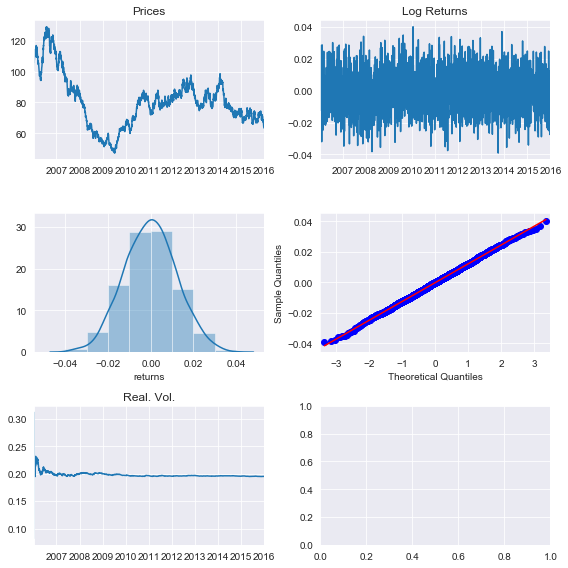

In [66]:
plot_data(df)

Realized volatility converges to instantaneous volatility.

### DAX Index

In [38]:
with open('C:/Users/Alex/Documents/quandl_key.txt', 'r') as f:
    quandl.ApiConfig.api_key = f.read()

# can't pull in index values
tickers = ['AAPL']
data = quandl.get_table('WIKI/PRICES', 
                        ticker=tickers,
                        qopts={'columns':['ticker', 'date', 'adj_close']},
                        date={'gte':'2004-10-1', 'lte':'2014-9-30'},
                        paginate=True
                       ).set_index('date')
df = data.pivot(columns='ticker', values='adj_close')
df.columns=['prices']
df.head()

,prices
date,
2004-10-01,2.484817
2004-10-04,2.492528
2004-10-05,2.529797
2004-10-06,2.611403
2004-10-07,2.545861


In [40]:
df['returns'] = np.log(df['prices'].pct_change(1) + 1)
df['real_var'] = 252 * np.cumsum(df['returns'] ** 2) / np.arange(df.shape[0])
df['real_vol'] = np.sqrt(df['real_var'])
df.dropna(inplace=True)

In [41]:
print_statistics(df)

RETURN SAMPLE STATISTICS
---------------------------------------------
Mean of Daily  Log Returns  0.001449
Std  of Daily  Log Returns  0.022731
Mean of Annua. Log Returns  0.365264
Std  of Annua. Log Returns  0.360842
---------------------------------------------
Skew of Sample Log Returns -0.175248
Skew Normal Test p-value    0.000354
---------------------------------------------
Kurt of Sample Log Returns  5.487174
Kurt Normal Test p-value    0.000000
---------------------------------------------
Normal Test p-value         0.000000
---------------------------------------------
Realized Volatility         0.361575
Realized Variance           0.130736


Negative skew and kurtosis are both supported by low p-test values, reject assumption of normality.

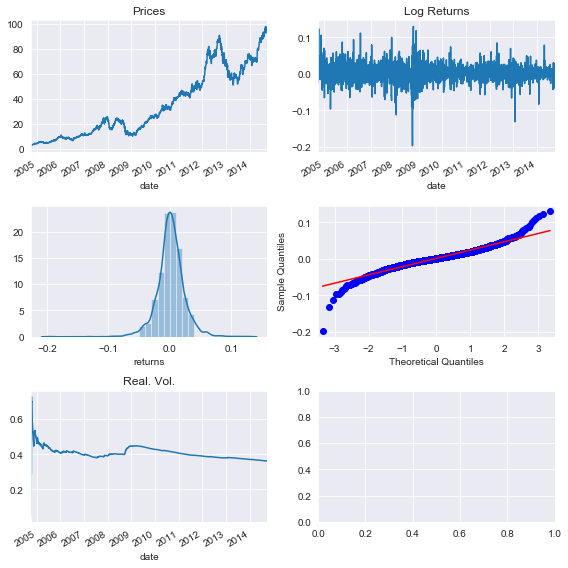

In [42]:
plot_data(df)

Volatility seems to be converging to a mean value of 0.40 prior to 2008 and then a value slightly lower than 0.40 after.
Supports assumption volatility is time varying.

### Rolling returns, vol, and correlation b/w

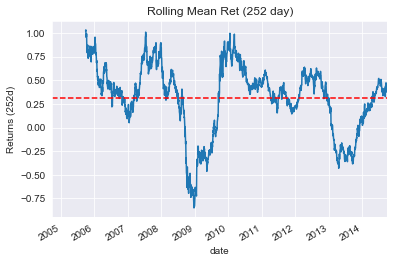

In [55]:
# f, axes = plt.subplots(3, 1)

roll_mean = df['returns'].rolling(252).mean() * 252
roll_mean.plot()
plt.grid(True)
plt.ylabel('Returns (252d)')
plt.title('Rolling Mean Ret (252 day)')
plt.axhline(roll_mean.mean(), color='r', ls='dashed', lw=1.5)

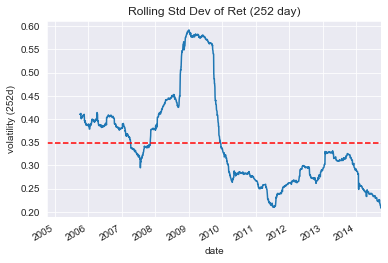

In [54]:
roll_std = df['returns'].rolling(252).std() * math.sqrt(252)
roll_std.plot()
plt.grid(True)
plt.ylabel('volatility (252d)')
plt.title('Rolling Std Dev of Ret (252 day)')
plt.axhline(roll_std.mean(), color='r', ls='dashed', lw=1.5)

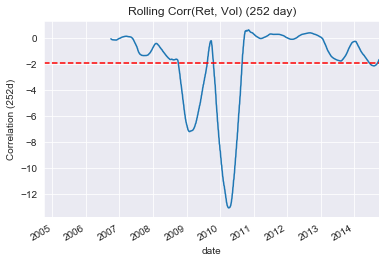

In [58]:
roll_std = roll_mean.rolling(252).cov(roll_std) * 252
roll_std.plot()
plt.grid(True)
plt.ylabel('Correlation (252d)')
plt.title('Rolling Corr(Ret, Vol) (252 day)')
plt.axhline(roll_std.mean(), color='r', ls='dashed', lw=1.5)

Negive relationship b/w correlation and log returns.

In [59]:
# URL of data file
es_url = 'http://www.stoxx.com/download/historical_values/hbrbcpe.txt'
# column names to be used
cols = ['Date', 'SX5P', 'SX5E', 'SXXP', 'SXXE',
        'SXXF', 'SXXA', 'DK5F', 'DKXF', 'DEL']
# reading the data with pandas
es = pd.read_csv(es_url,  # filename
                 header=None,  # ignore column names
                 index_col=0,  # index column (dates)
                 parse_dates=True,  # parse these dates
                 dayfirst=True,  # format of dates
                 skiprows=4,  # ignore these rows
                 sep=';',  # data separator
                 names=cols)  # use these column names
# deleting the helper column
del es['DEL']
S0 = es['SX5E']['30-09-2014']
r = -0.05

In [60]:
es

,SX5P,SX5E,SXXP,SXXE,SXXF,SXXA,DK5F,DKXF
Date,,,,,,,,
1986-12-31,775.00,900.82,82.76,98.58,98.06,69.06,645.26,65.56
1987-01-01,775.00,900.82,82.76,98.58,98.06,69.06,645.26,65.56
1987-01-02,770.89,891.78,82.57,97.80,97.43,69.37,647.62,65.81
1987-01-05,771.89,898.33,82.82,98.60,98.19,69.16,649.94,65.82
1987-01-06,775.92,902.32,83.28,99.19,98.83,69.50,652.49,66.06
...,...,...,...,...,...,...,...,...
2016-09-28,2846.55,2991.11,342.57,324.24,407.97,350.45,9072.09,581.27
2016-09-29,2848.93,2991.58,342.72,324.08,407.65,350.90,9112.09,582.60
2016-09-30,2843.17,3002.24,342.92,325.31,408.27,350.09,9115.81,583.26
